# Lag Selection: feature selection & modelling using LASSO
22 March 2024   
Conda environment: `time-series`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler # z = (x - u) / s

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
filename = "../datasets/AirQualityUCI_ready.csv"
data = pd.read_csv(filename, parse_dates=["Date_Time"], index_col=["Date_Time"])

data.sort_index(inplace=True)
data.head()

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6000,"1,360.0000",150.0000,11.9000,"1,046.0000",166.0000,"1,056.0000",113.0000,"1,692.0000","1,268.0000",13.6000,48.9000,0.7578
2004-03-10 19:00:00,2.0000,"1,292.0000",112.0000,9.4000,955.0000,103.0000,"1,174.0000",92.0000,"1,559.0000",972.0000,13.3000,47.7000,0.7255
2004-03-10 20:00:00,2.2000,"1,402.0000",88.0000,9.0000,939.0000,131.0000,"1,140.0000",114.0000,"1,555.0000","1,074.0000",11.9000,54.0000,0.7502
2004-03-10 21:00:00,2.2000,"1,376.0000",80.0000,9.2000,948.0000,172.0000,"1,092.0000",122.0000,"1,584.0000","1,203.0000",11.0000,60.0000,0.7867
2004-03-10 22:00:00,1.6000,"1,272.0000",51.0000,6.5000,836.0000,131.0000,"1,205.0000",116.0000,"1,490.0000","1,110.0000",11.2000,59.6000,0.7888


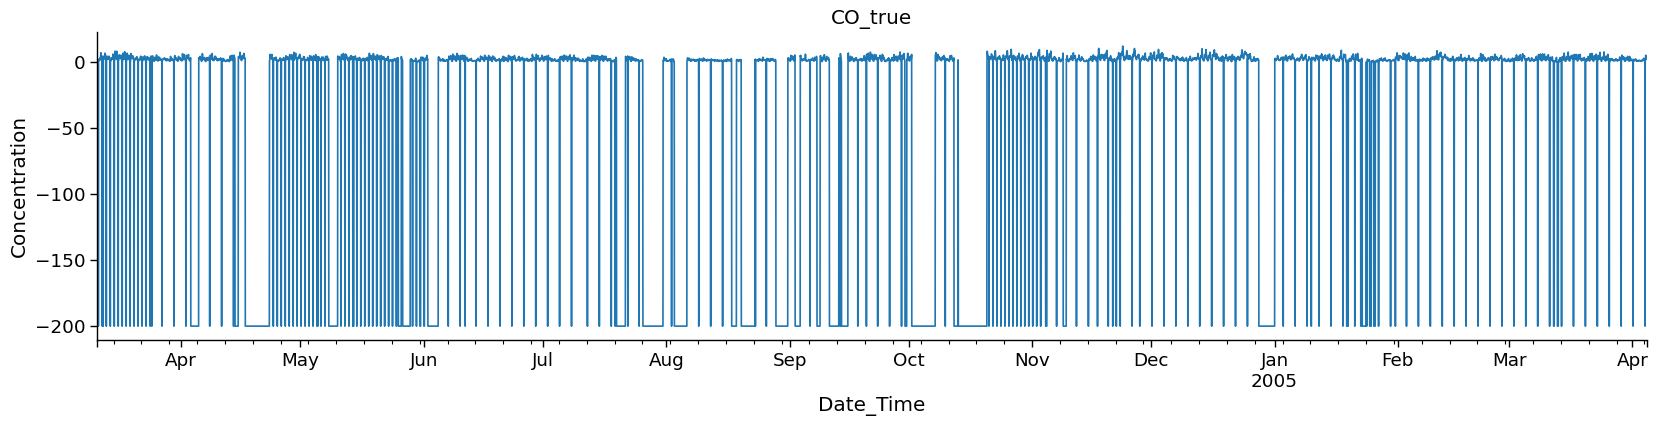

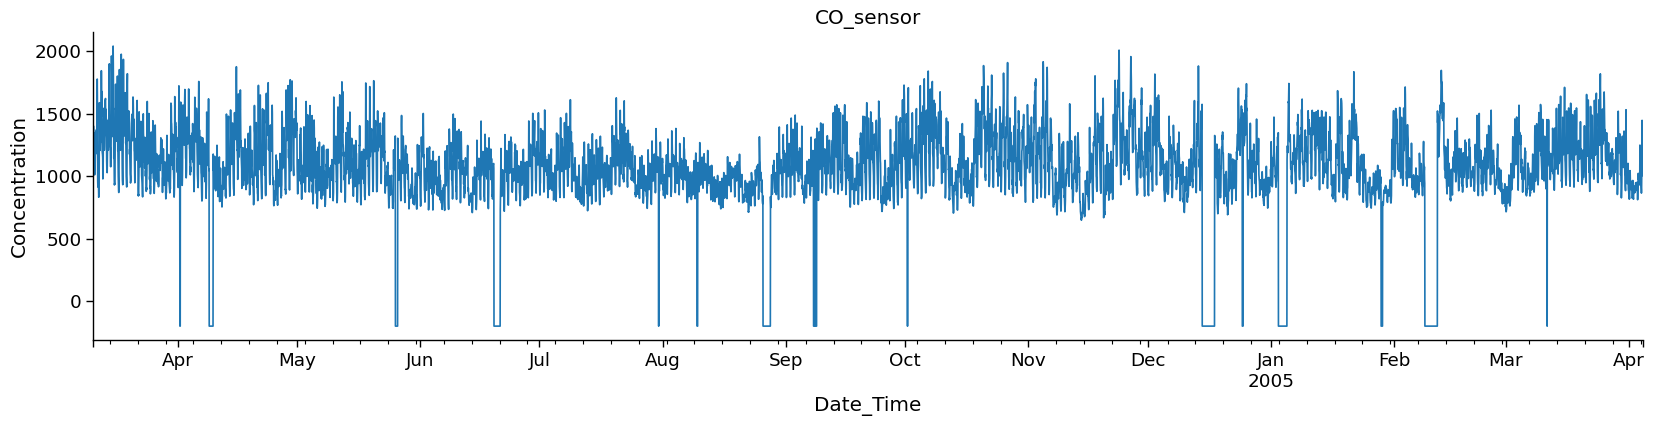

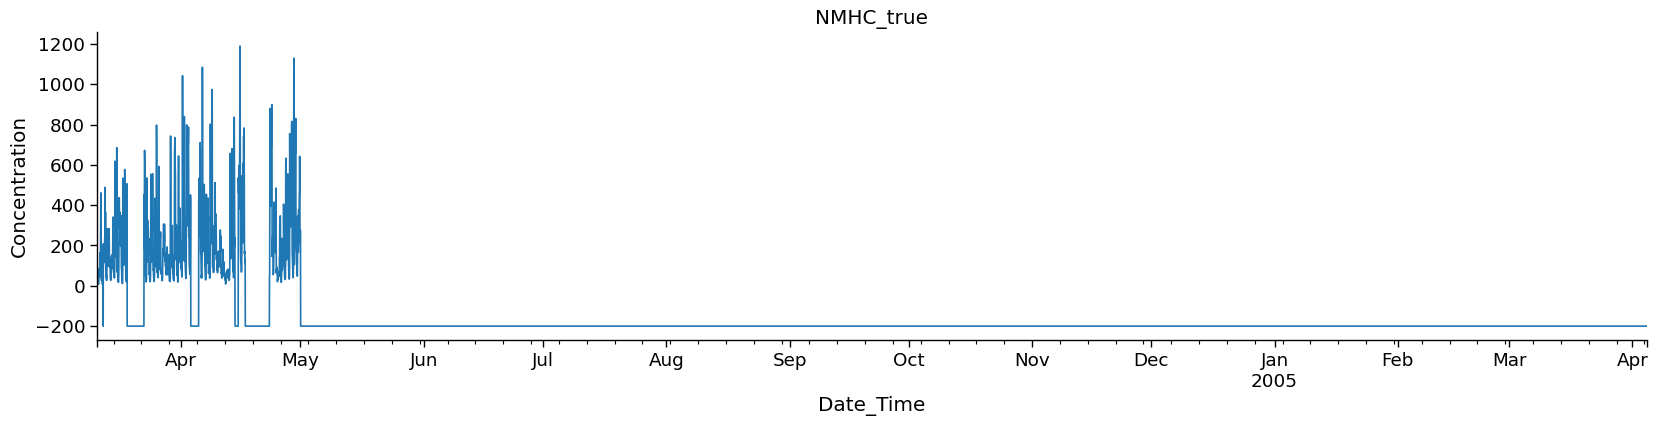

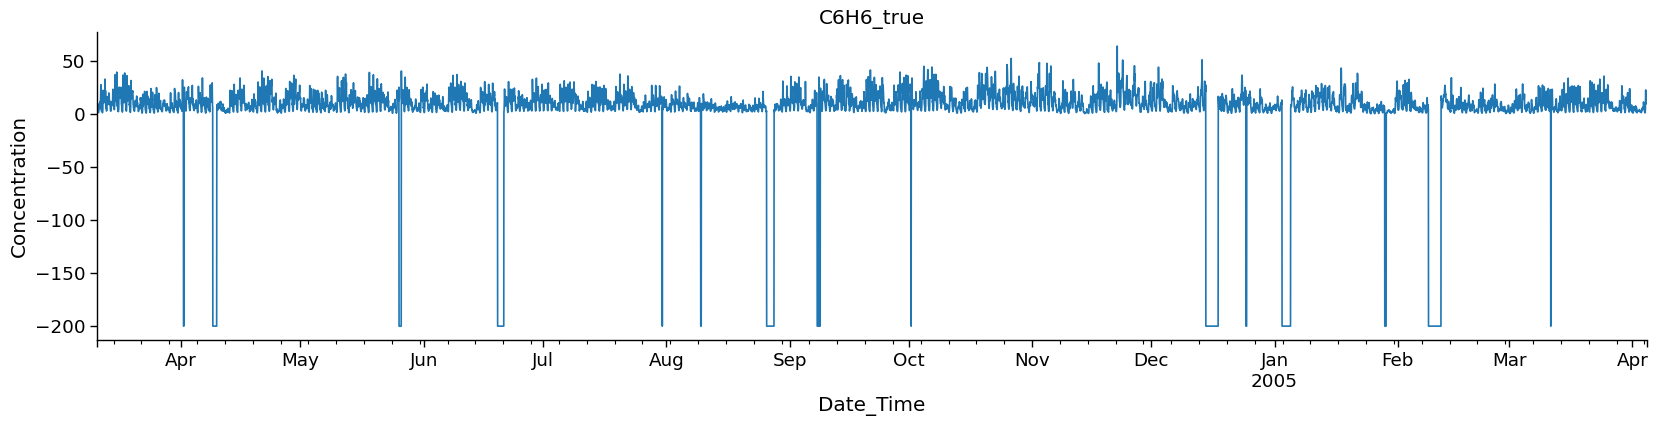

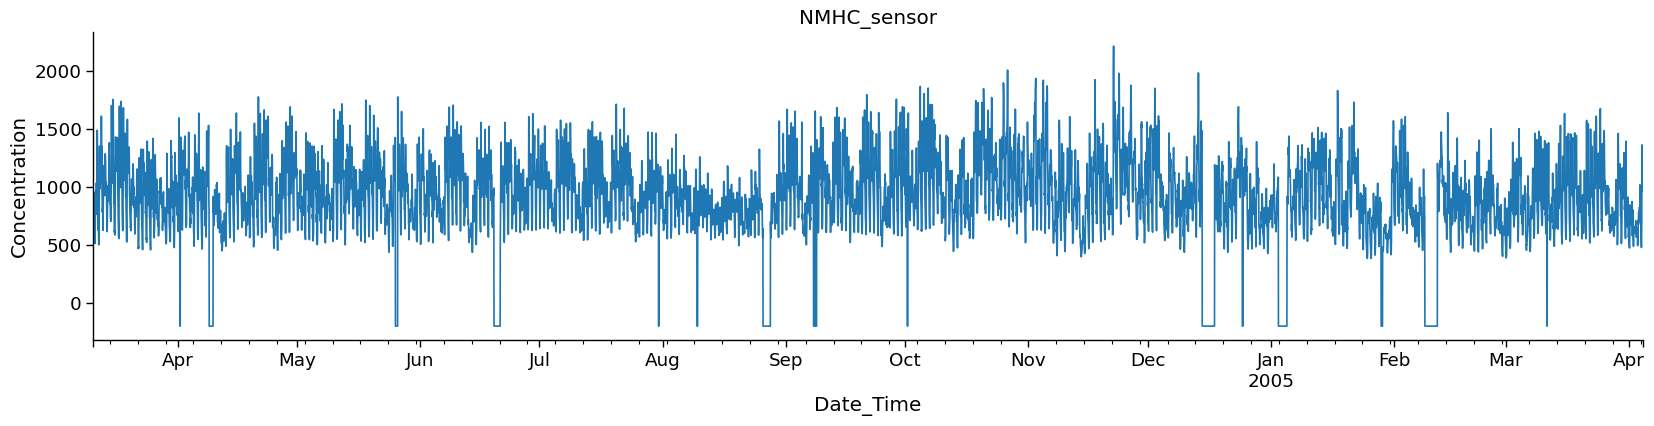

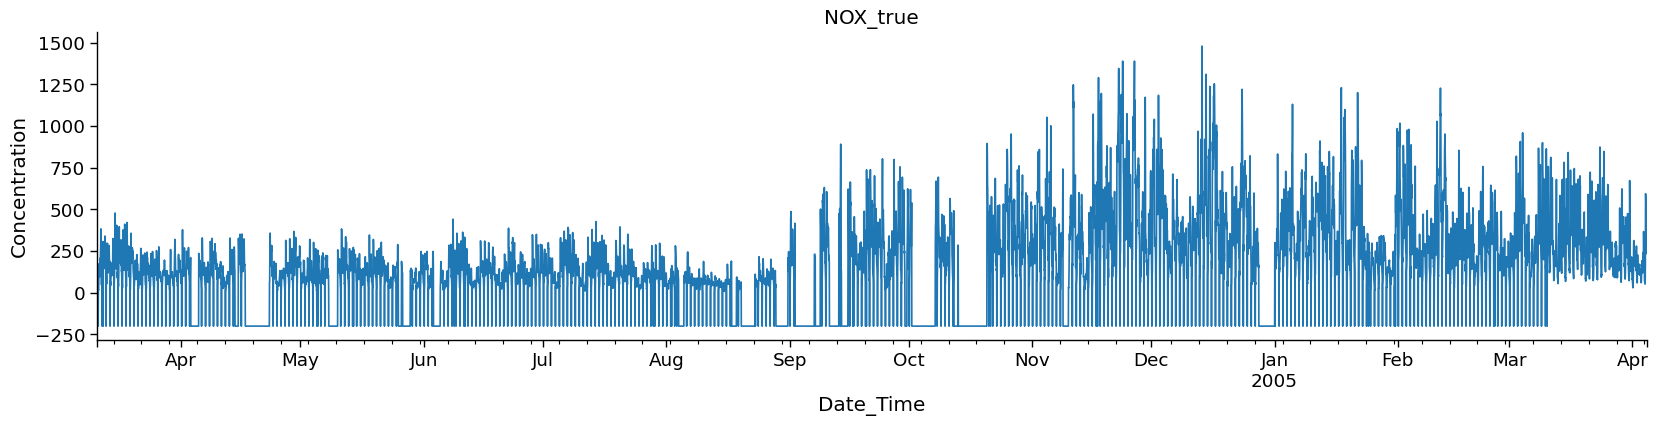

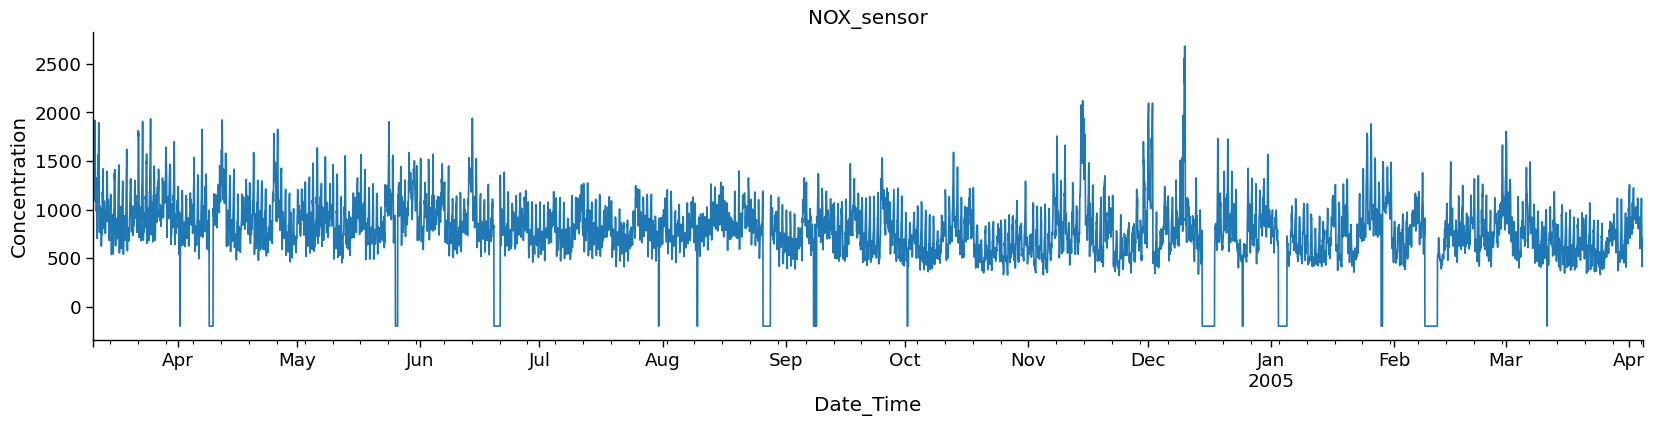

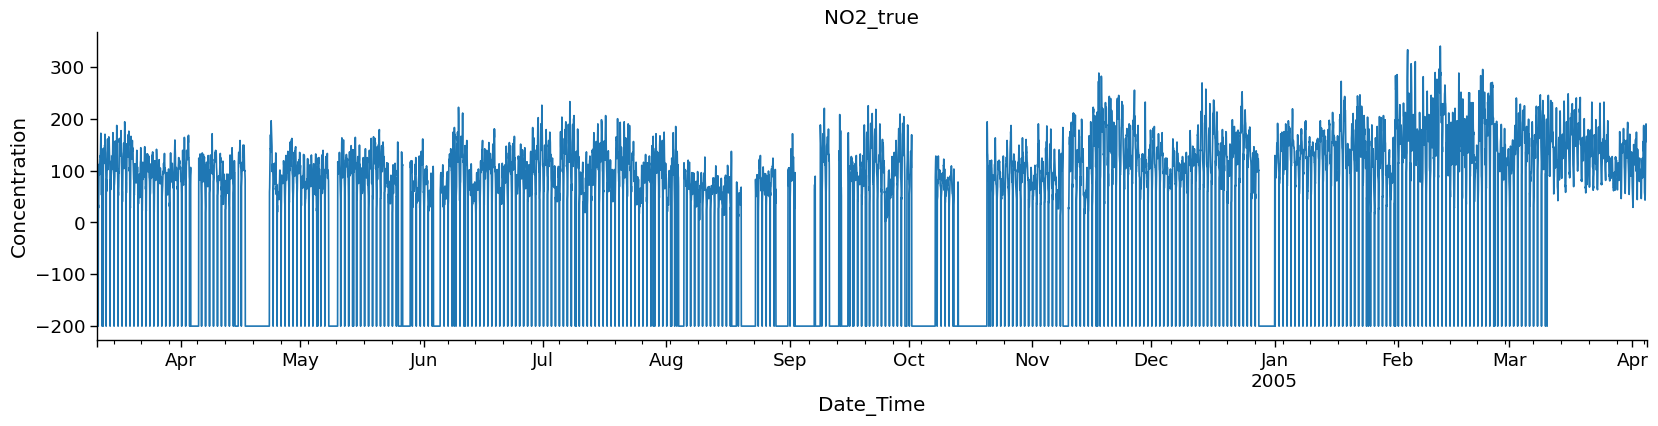

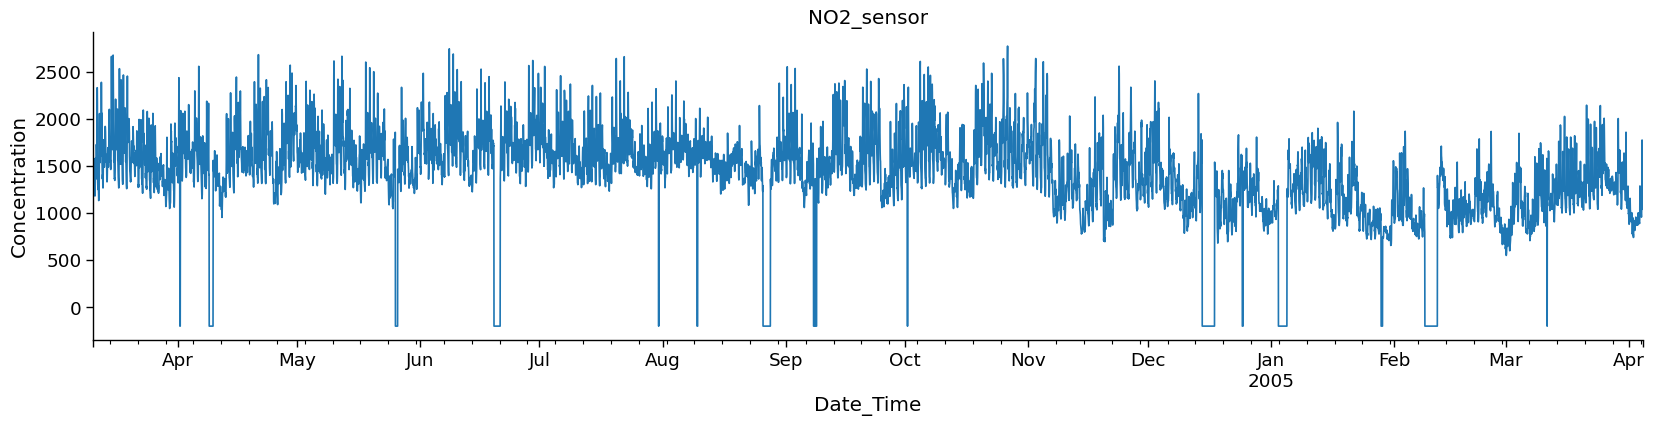

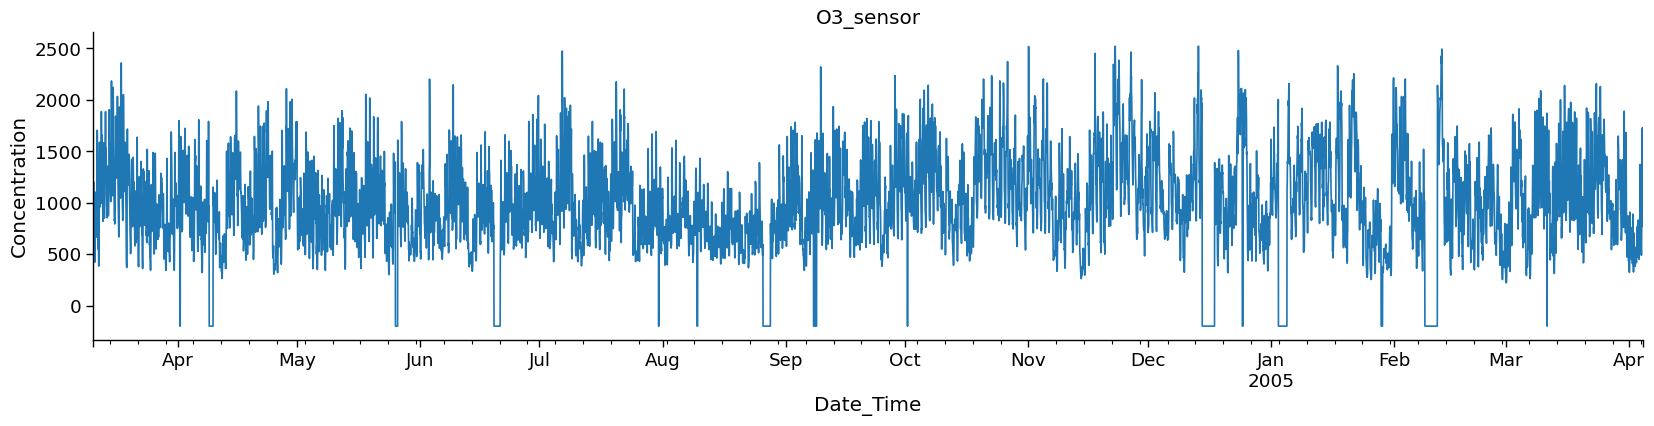

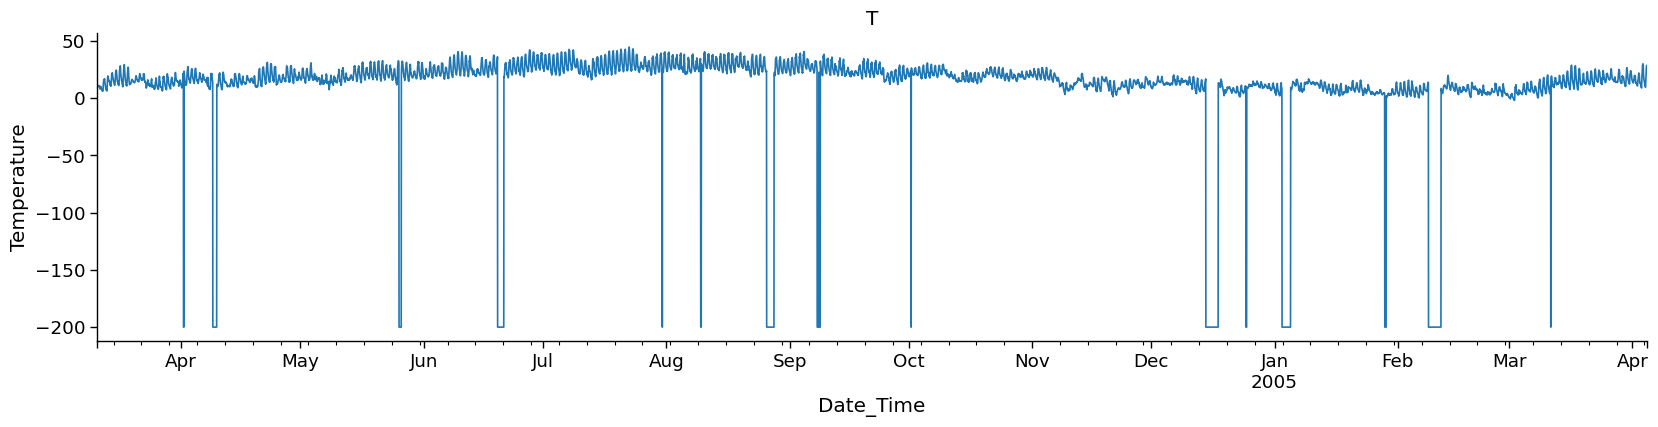

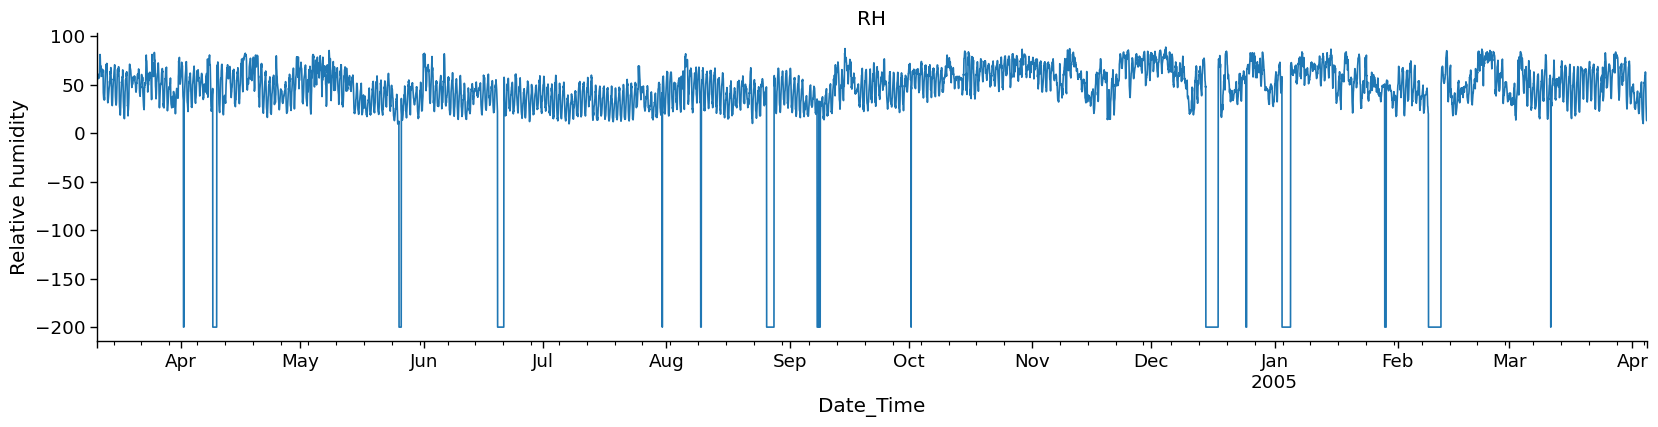

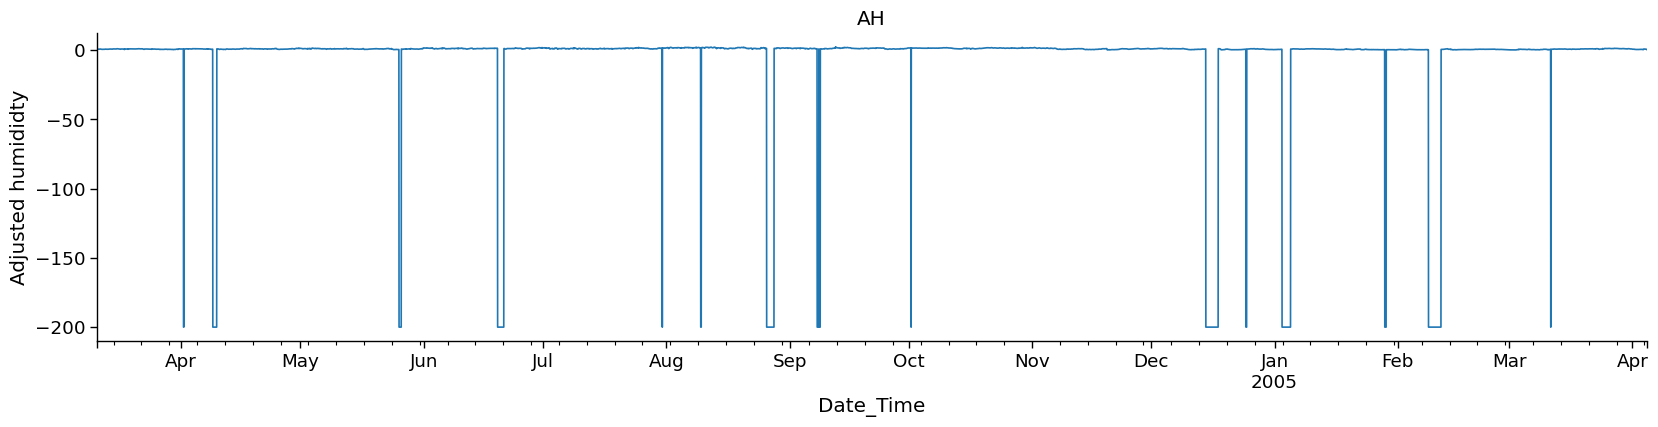

In [4]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

### 1.1) Preprocessing Data

In [5]:
# Reduce the time span
data = data["2004-04-01":"2005-04-30"]
# Resample freq to be hourly. If there are gaps larger than one hour they will be representing as NaNs.
data = data.asfreq("1H")
# Remove measurements from fixed stations. We'll only be using sensor data.
drop_vars = [var for var in data.columns if "_true" in var]
# Remove adjusted humidity.
drop_vars.append("AH")

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)
# Impute negative values with NaNs
data[data < 0] = np.NaN

data

,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,
2004-04-01 00:00:00,"1,143.0000",825.0000,986.0000,"1,477.0000",978.0000,12.0000,61.6000
2004-04-01 01:00:00,"1,044.0000",770.0000,"1,031.0000","1,425.0000",944.0000,11.5000,63.9000
2004-04-01 02:00:00,"1,034.0000",716.0000,"1,085.0000","1,405.0000",891.0000,10.7000,67.2000
2004-04-01 03:00:00,956.0000,713.0000,"1,099.0000","1,422.0000",849.0000,9.0000,73.1000
2004-04-01 04:00:00,909.0000,615.0000,"1,237.0000","1,322.0000",790.0000,10.2000,66.6000
...,...,...,...,...,...,...,...
2005-04-04 10:00:00,"1,314.0000","1,101.0000",539.0000,"1,374.0000","1,729.0000",21.9000,29.3000
2005-04-04 11:00:00,"1,163.0000","1,027.0000",604.0000,"1,264.0000","1,269.0000",24.3000,23.7000
2005-04-04 12:00:00,"1,142.0000","1,063.0000",603.0000,"1,241.0000","1,092.0000",26.9000,18.3000


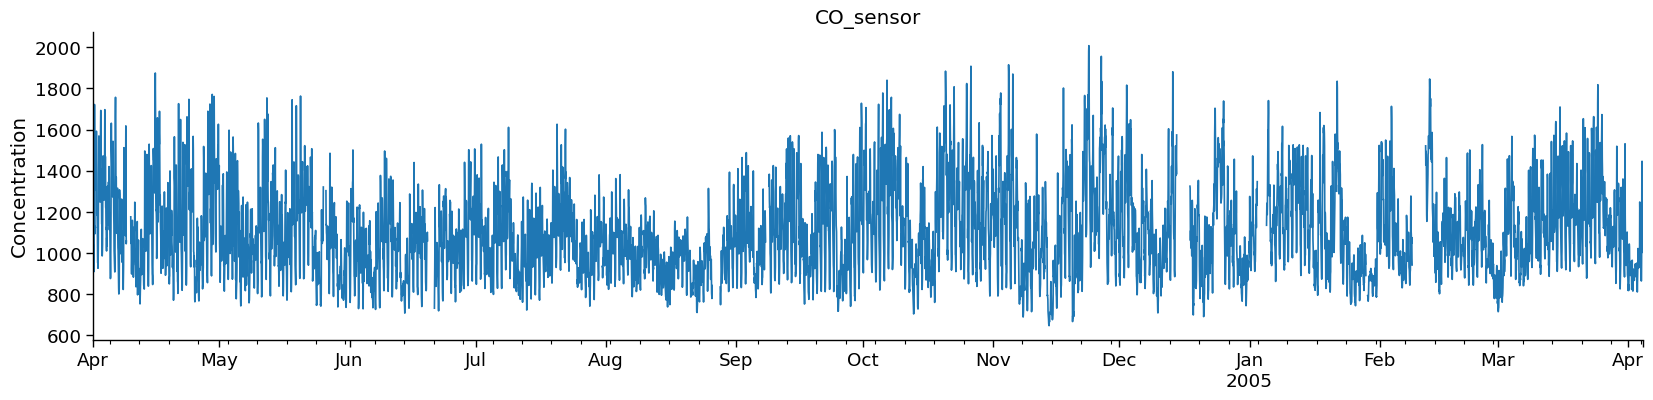

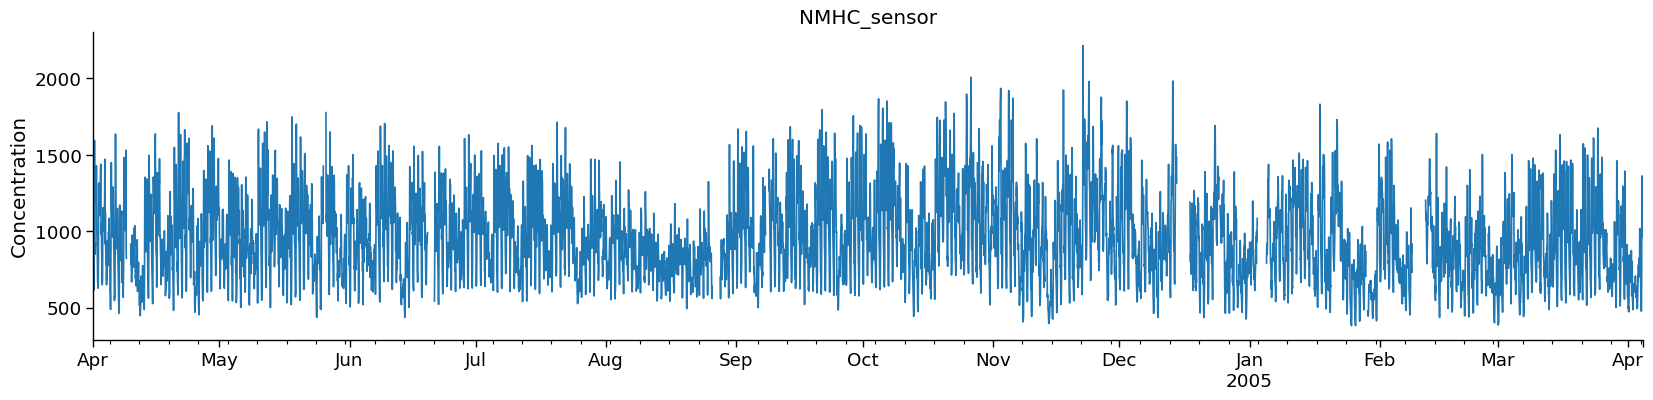

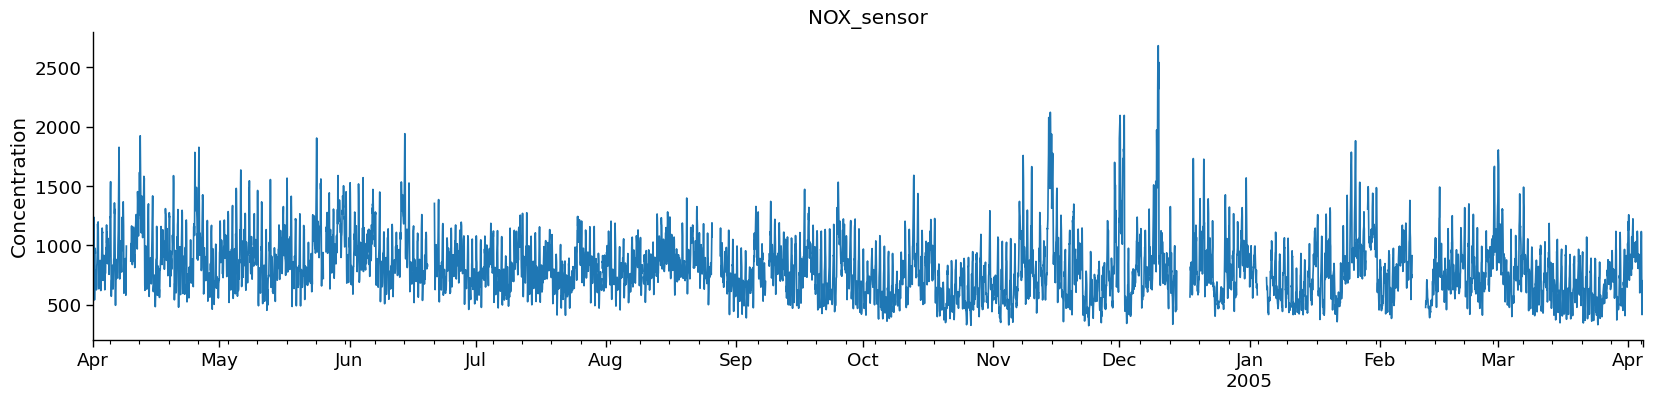

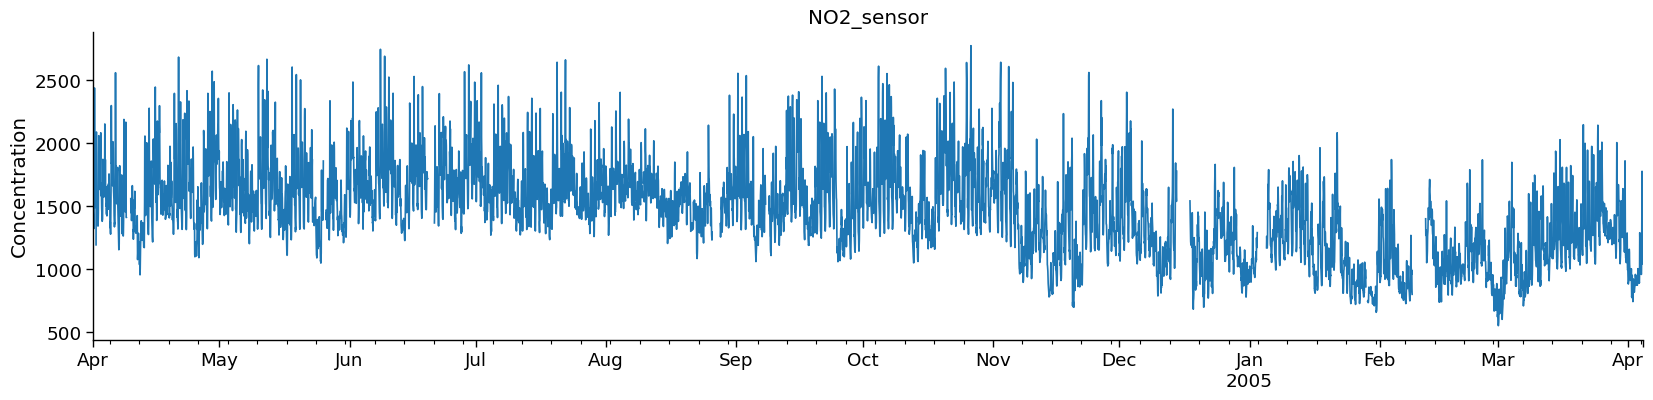

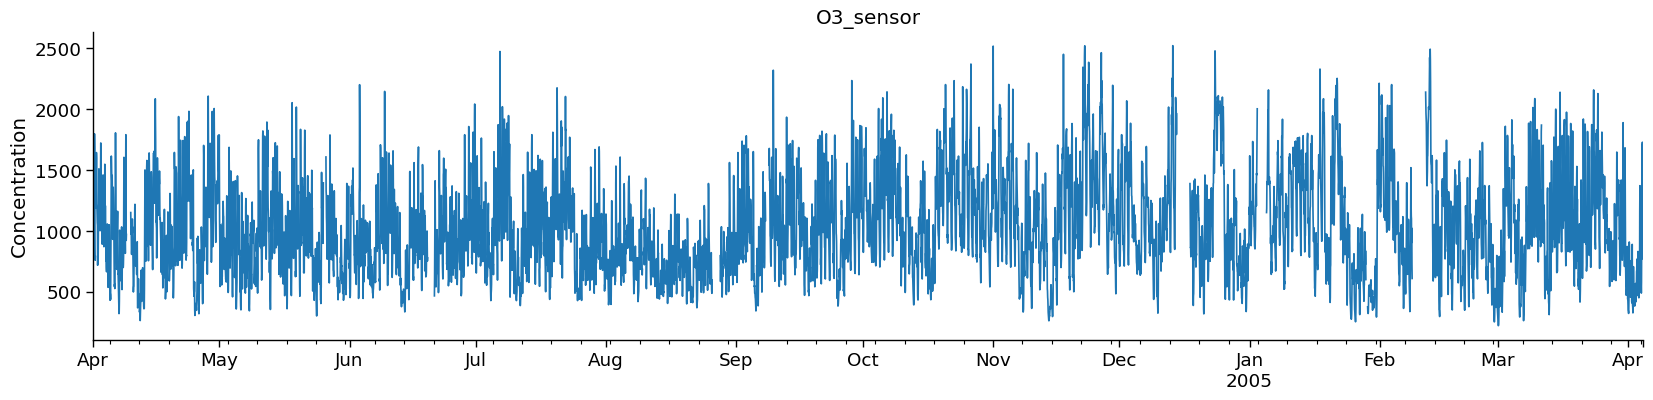

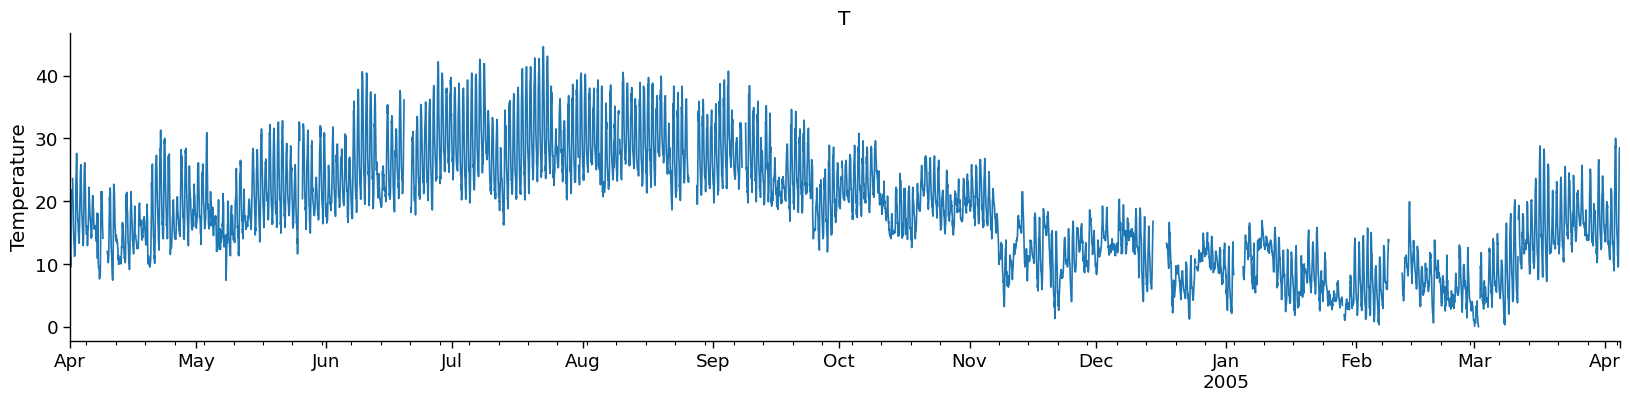

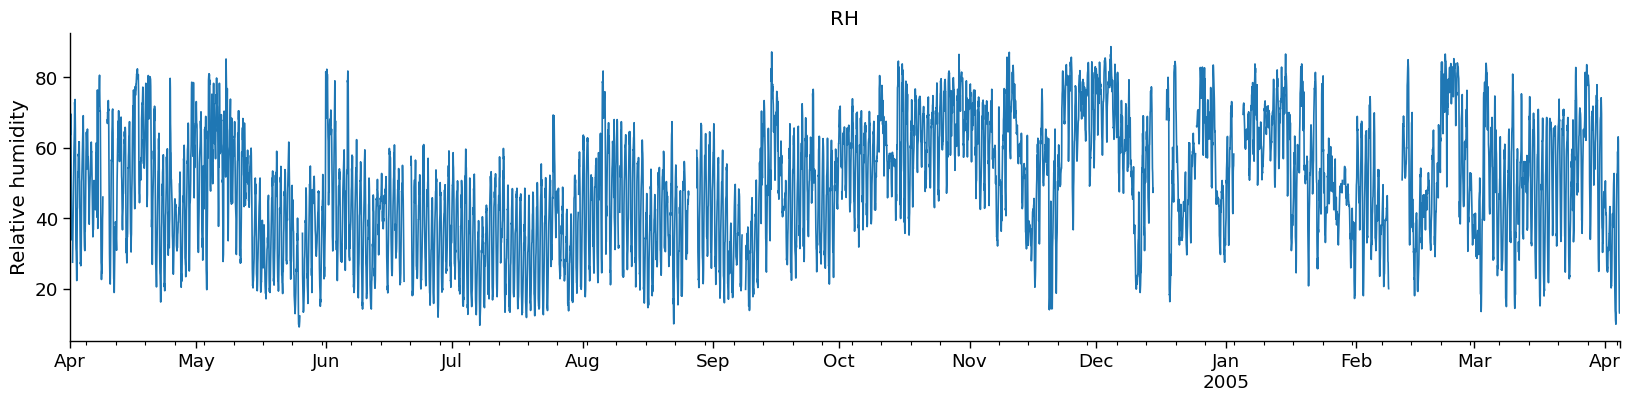

In [6]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.xlabel("")
    plt.show()

## 2) Feature selection & modelling
We are going to use `LASSO` to determine a small set of features from all the lag features that may be helpful for forecasting.   

**NOTE**: LASSO tends to pick one as important and zero out the other features.

In [7]:
target = "NO2_sensor"
raw_features = ["CO_sensor", "NMHC_sensor", "NOX_sensor", "O3_sensor", "T", "RH"]

df = data.copy(deep=True)

# Fill missing data
df = df.fillna(method="ffill")
df.head()

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_14961/3380156029.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,
2004-04-01 00:00:00,"1,143.0000",825.0000,986.0000,"1,477.0000",978.0000,12.0000,61.6000
2004-04-01 01:00:00,"1,044.0000",770.0000,"1,031.0000","1,425.0000",944.0000,11.5000,63.9000
2004-04-01 02:00:00,"1,034.0000",716.0000,"1,085.0000","1,405.0000",891.0000,10.7000,67.2000
2004-04-01 03:00:00,956.0000,713.0000,"1,099.0000","1,422.0000",849.0000,9.0000,73.1000
2004-04-01 04:00:00,909.0000,615.0000,"1,237.0000","1,322.0000",790.0000,10.2000,66.6000


There is one years worth of data, thus we will avoid creating large lags.   
We will create multiple lags from 1 hour to 1 week ago in hourly increments.

In [8]:
freqs = [f"{i}H" for i in range(1, 24*7)]
print(f"Number of lags: {len(freqs)}")

# Create lag features for all the features and the target
features_to_lag = raw_features + [target]
lag = LagFeatures(variables=features_to_lag, freq=freqs)
df = lag.fit_transform(df)
# Drop NaNs introduced by laggin
df = df.dropna()
df.head()

Number of lags: 167


,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,CO_sensor_lag_1H,NMHC_sensor_lag_1H,NOX_sensor_lag_1H,O3_sensor_lag_1H,T_lag_1H,RH_lag_1H,NO2_sensor_lag_1H,CO_sensor_lag_2H,NMHC_sensor_lag_2H,NOX_sensor_lag_2H,O3_sensor_lag_2H,T_lag_2H,RH_lag_2H,NO2_sensor_lag_2H,CO_sensor_lag_3H,NMHC_sensor_lag_3H,NOX_sensor_lag_3H,O3_sensor_lag_3H,T_lag_3H,RH_lag_3H,NO2_sensor_lag_3H,CO_sensor_lag_4H,NMHC_sensor_lag_4H,NOX_sensor_lag_4H,O3_sensor_lag_4H,T_lag_4H,RH_lag_4H,NO2_sensor_lag_4H,CO_sensor_lag_5H,NMHC_sensor_lag_5H,NOX_sensor_lag_5H,O3_sensor_lag_5H,T_lag_5H,RH_lag_5H,NO2_sensor_lag_5H,CO_sensor_lag_6H,NMHC_sensor_lag_6H,NOX_sensor_lag_6H,O3_sensor_lag_6H,T_lag_6H,RH_lag_6H,NO2_sensor_lag_6H,CO_sensor_lag_7H,NMHC_sensor_lag_7H,NOX_sensor_lag_7H,O3_sensor_lag_7H,T_lag_7H,RH_lag_7H,NO2_sensor_lag_7H,CO_sensor_lag_8H,NMHC_sensor_lag_8H,NOX_sensor_lag_8H,O3_sensor_lag_8H,T_lag_8H,RH_lag_8H,NO2_sensor_lag_8H,CO_sensor_lag_9H,NMHC_sensor_lag_9H,NOX_sensor_lag_9H,O3_sensor_lag_9H,T_lag_9H,RH_lag_9H,NO2_sensor_lag_9H,CO_sensor_lag_10H,NMHC_sensor_lag_10H,NOX_sensor_lag_10H,O3_sensor_lag_10H,T_lag_10H,RH_lag_10H,NO2_sensor_lag_10H,CO_sensor_lag_11H,NMHC_sensor_lag_11H,NOX_sensor_lag_11H,O3_sensor_lag_11H,T_lag_11H,RH_lag_11H,NO2_sensor_lag_11H,CO_sensor_lag_12H,NMHC_sensor_lag_12H,NOX_sensor_lag_12H,O3_sensor_lag_12H,T_lag_12H,RH_lag_12H,NO2_sensor_lag_12H,CO_sensor_lag_13H,NMHC_sensor_lag_13H,NOX_sensor_lag_13H,O3_sensor_lag_13H,T_lag_13H,RH_lag_13H,NO2_sensor_lag_13H,CO_sensor_lag_14H,NMHC_sensor_lag_14H,...,RH_lag_153H,NO2_sensor_lag_153H,CO_sensor_lag_154H,NMHC_sensor_lag_154H,NOX_sensor_lag_154H,O3_sensor_lag_154H,T_lag_154H,RH_lag_154H,NO2_sensor_lag_154H,CO_sensor_lag_155H,NMHC_sensor_lag_155H,NOX_sensor_lag_155H,O3_sensor_lag_155H,T_lag_155H,RH_lag_155H,NO2_sensor_lag_155H,CO_sensor_lag_156H,NMHC_sensor_lag_156H,NOX_sensor_lag_156H,O3_sensor_lag_156H,T_lag_156H,RH_lag_156H,NO2_sensor_lag_156H,CO_sensor_lag_157H,NMHC_sensor_lag_157H,NOX_sensor_lag_157H,O3_sensor_lag_157H,T_lag_157H,RH_lag_157H,NO2_sensor_lag_157H,CO_sensor_lag_158H,NMHC_sensor_lag_158H,NOX_sensor_lag_158H,O3_sensor_lag_158H,T_lag_158H,RH_lag_158H,NO2_sensor_lag_158H,CO_sensor_lag_159H,NMHC_sensor_lag_159H,NOX_sensor_lag_159H,O3_sensor_lag_159H,T_lag_159H,RH_lag_159H,NO2_sensor_lag_159H,CO_sensor_lag_160H,NMHC_sensor_lag_160H,NOX_sensor_lag_160H,O3_sensor_lag_160H,T_lag_160H,RH_lag_160H,NO2_sensor_lag_160H,CO_sensor_lag_161H,NMHC_sensor_lag_161H,NOX_sensor_lag_161H,O3_sensor_lag_161H,T_lag_161H,RH_lag_161H,NO2_sensor_lag_161H,CO_sensor_lag_162H,NMHC_sensor_lag_162H,NOX_sensor_lag_162H,O3_sensor_lag_162H,T_lag_162H,RH_lag_162H,NO2_sensor_lag_162H,CO_sensor_lag_163H,NMHC_sensor_lag_163H,NOX_sensor_lag_163H,O3_sensor_lag_163H,T_lag_163H,RH_lag_163H,NO2_sensor_lag_163H,CO_sensor_lag_164H,NMHC_sensor_lag_164H,NOX_sensor_lag_164H,O3_sensor_lag_164H,T_lag_164H,RH_lag_164H,NO2_sensor_lag_164H,CO_sensor_lag_165H,NMHC_sensor_lag_165H,NOX_sensor_lag_165H,O3_sensor_lag_165H,T_lag_165H,RH_lag_165H,NO2_sensor_lag_165H,CO_sensor_lag_166H,NMHC_sensor_lag_166H,NOX_sensor_lag_166H,O3_sensor_lag_166H,T_lag_166H,RH_lag_166H,NO2_sensor_lag_166H,CO_sensor_lag_167H,NMHC_sensor_lag_167H,NOX_sensor_lag_167H,O3_sensor_lag_167H,T_lag_167H,RH_lag_167H,NO2_sensor_lag_167H
Date_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-04-07 23:00:00,"1,107.0000",861.0000,957.0000,"1,510.0000",879.0000,9.6000,76.0000,"1,020.0000",727.0000,"1,153.0000",631.0000,9.3000,75.2000,"1,391.0000",956.0000,666.0000,"1,235.0000",518.0000,9.8000,71.8000,"1,282.0000","1,207.0000","1,013.0000",876.0000,982.0000,10.0000,74.0000,"1,632.0000","1,262.0000","1,133.0000",774.0000,"1,033.0000",11.3000,71.3000,"1,748.0000","1,221.0000","1,101.0000",799.0000,996.0000,14.7000,48.7000,"1,700.0000","1,171.0000","1,073.0000",847.0000,872.0000,18.0000,37.1000,"1,6

In [9]:
# We will only use lag features to avoid data leakage
features = [col for col in df.columns if "lag" in col]
print(f"Number of features {len(features): ,.0f}")

Number of features  1,169


### 2.1) Features/Target Split

In [13]:
# Because LASSO is a linear model which uses regression, we are going to scale the dataset.
y = StandardScaler().fit_transform(df[target].to_frame())
X = StandardScaler().fit_transform(df[features])

# LASSO model
ALPHA = 1
model = Lasso(alpha=ALPHA).fit(X,y)

We observe `alpha` is to high and forces all features to zero.

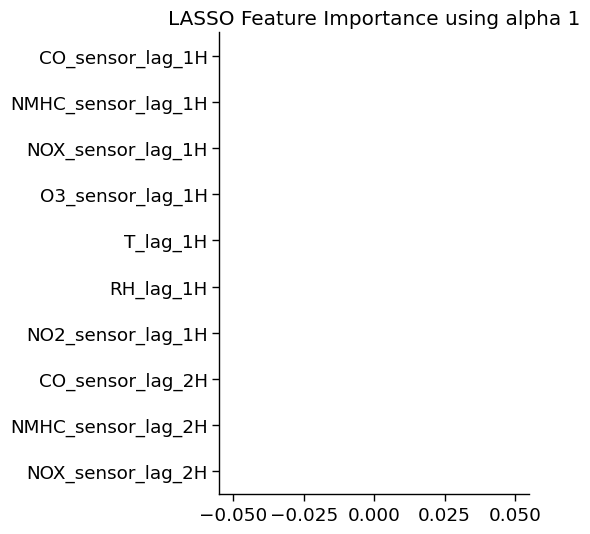

In [24]:
feature_importance = pd.Series(index=features, data=model.coef_)
TOP_N = 10
feature_importance\
    .abs()\
    .nlargest(TOP_N)\
    [::-1]\
    .plot(kind="barh", figsize=(4,6))

plt.title(f"LASSO Feature Importance using alpha {ALPHA}")
plt.show()

We observe that the most important lags are:
* 1h lag of our target
* 1day lag of our target
* 1week lag of our target

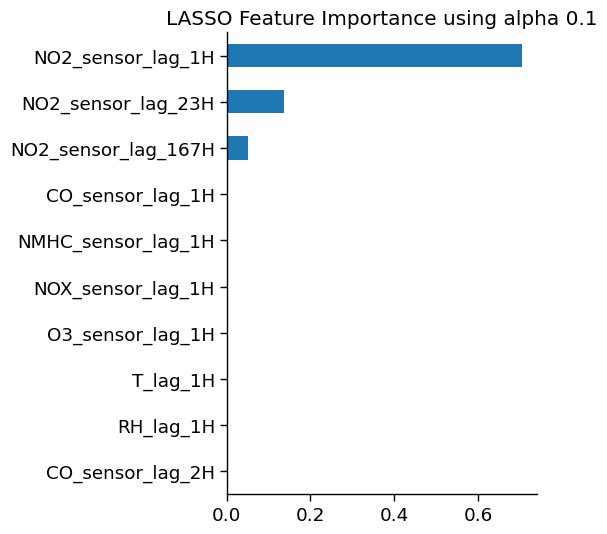

In [25]:
# LASSO model
ALPHA = 0.1
model = Lasso(alpha=ALPHA).fit(X,y)

# Barplot
feature_importance = pd.Series(index=features, data=model.coef_)
TOP_N = 10
feature_importance\
    .abs()\
    .nlargest(TOP_N)\
    [::-1]\
    .plot(kind="barh", figsize=(4,6))

plt.title(f"LASSO Feature Importance using alpha {ALPHA}")
plt.show()

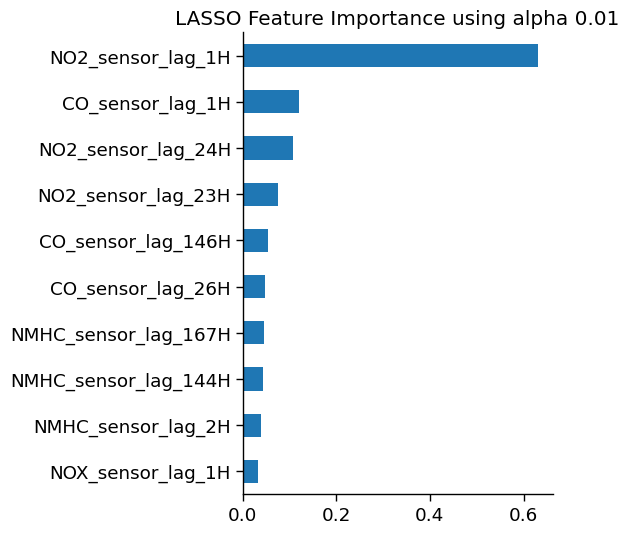

In [26]:
# LASSO model
ALPHA = 0.01
model = Lasso(alpha=ALPHA).fit(X,y)

# Barplot
feature_importance = pd.Series(index=features, data=model.coef_)
TOP_N = 10
feature_importance\
    .abs()\
    .nlargest(TOP_N)\
    [::-1]\
    .plot(kind="barh", figsize=(4,6))

plt.title(f"LASSO Feature Importance using alpha {ALPHA}")
plt.show()